# Chest X-ray Image Denoising with Autoencoders

In [3]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tqdm import tqdm
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

In [4]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150  # Image size (150x150)

def get_data(data_dir):
    data = []  # List to hold images
    
    for label in labels:
        path = os.path.join(data_dir, label)  # Folder path for each label
        
        for img in tqdm(os.listdir(path)):
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            if img_arr is None:
                print(f'Error reading image: {img}')
                continue
            resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize image to 150x150

            # Normalize the image to range [0, 1]
            resized_arr = resized_arr.astype(np.float32) / 255.0
            
            # Append the image to the data list
            data.append(resized_arr)
    
    # Convert data into a numpy array
    data = np.array(data)  # Shape will be (num_samples, img_size, img_size)
    
    # Add channel dimension (grayscale images will have 1 channel)
    data = np.expand_dims(data, axis=-1)  # Shape becomes (num_samples, img_size, img_size, 1)
    
    return data

# Load data (without labels)
train_data = get_data(r'/kaggle/input/chest-xray-pneumonia/chest_xray/train')
test_data = get_data(r'/kaggle/input/chest-xray-pneumonia/chest_xray/test')
val_data = get_data(r'/kaggle/input/chest-xray-pneumonia/chest_xray/val')

# Check the shape of the data
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"Validation data shape: {val_data.shape}")

100%|██████████| 8/8 [00:00<00:00, 122.33it/s]

Train data shape: (5216, 150, 150, 1)
Test data shape: (624, 150, 150, 1)
Validation data shape: (16, 150, 150, 1)


# Adding noise to images

In [12]:
#Adding Noise to the images
# Define the noise factor
noise_fac = 0.4
val_data_noisy=np.empty((3, 3))
# Function to add noise to a dataset
def add_noise(data, noise_factor=noise_fac):
    noise_data = []
    for image in data:
        # Add random noise to the image
        noise = image + noise_factor * np.random.rand(*image.shape)  # Generate random noise
        noise = np.clip(noise, 0, 1)  # Ensure pixel values are between 0 and 1
        noise_data.append(noise)
    
    # Convert the list of noisy images back to a NumPy array
    return np.array(noise_data)

# Add noise to each dataset
train_data_noisy = add_noise(train_data)
test_data_noisy = add_noise(test_data)
val_data_noisy = add_noise(val_data)

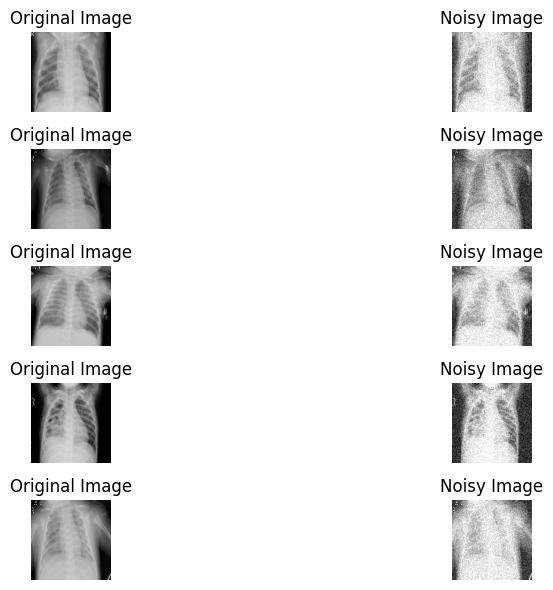

In [13]:
# Select a subset of images to visualize.
num_images = 5

# Plot the original images and the noisy images side by side
plt.figure(figsize=(12, 6))
for i in range(num_images):
    # Original (clean) image
    plt.subplot(num_images, 2, 2*i + 1)
    plt.imshow(val_data[i].reshape(150, 150), cmap='gray')  # Reshape to (150, 150) for correct display
    plt.title("Original Image")
    plt.axis('off')

    # Noisy image
    plt.subplot(num_images, 2, 2*i + 2)
    plt.imshow(val_data_noisy[i].reshape(150, 150), cmap='gray')  # Reshape to (150, 150) for correct display
    plt.title("Noisy Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Building Denoising model with Autoencoder 

In [14]:
# Define the autoencoder architecture using Keras
def build_denoising_autoencoder(img_size):
    # Encoder
    input_img = layers.Input(shape=(img_size, img_size, 1))  # Input shape is (150, 150, 1) for grayscale images
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    # Final convolutional layer
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Sigmoid to match the [0, 1] pixel range

    # Crop the output to match the input size exactly (150x150)
    cropped_output = layers.Cropping2D(cropping=((1, 1), (1, 1)))(decoded)  # Crop 1 pixel from each side
    
    # Compile the autoencoder model
    autoencoder = models.Model(input_img, cropped_output)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return autoencoder

# Build the autoencoder model
autoencoder = build_denoising_autoencoder(img_size=150)

# Train the autoencoder
autoencoder.summary()

# Train the model
autoencoder.fit(
    train_data_noisy,  # Noisy images (input)
    train_data,        # Clean images (target)
    epochs=10,         # Number of epochs
    batch_size=64,     # Batch size
    validation_data=(val_data_noisy, val_data),  # Validation data
)

# Save the trained model
autoencoder.save('denoising_autoencoder_keras.h5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 38, 38, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 19, 19, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 38, 38, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 76, 76, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 76, 76, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 152, 152, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 152, 152, 1)         │             289 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ cropping2d_1 (Cropping2D)            │ (None, 150, 150, 1)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.0428 - loss: 0.6292 - val_accuracy: 0.0657 - val_loss: 0.5489
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0496 - loss: 0.5738 - val_accuracy: 0.0657 - val_loss: 0.5479
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0480 - loss: 0.5716 - val_accuracy: 0.0657 - val_loss: 0.5451
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0483 - loss: 0.5689 - val_accuracy: 0.0658 - val_loss: 0.5446
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0488 - loss: 0.5686 - val_accuracy: 0.0657 - val_loss: 0.5494
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0476 - loss: 0.5694 - val_accuracy: 0.0658 - val_loss: 0.5439
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0481 - loss: 0.5678 - val_accuracy: 0.0658 - val_loss: 0.5438
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.0479 - loss: 0.5672 - val_accuracy: 0.0658 - 

# Testing the model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


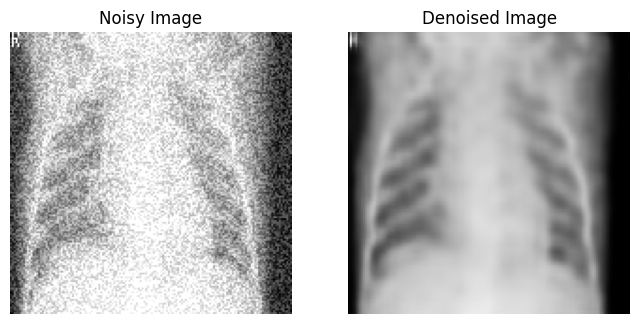

In [15]:
# Load the trained model (if needed)
autoencoder = models.load_model('denoising_autoencoder_keras.h5')

# Denoise a sample image
sample_noisy_image = val_data_noisy[0]  # Example noisy image
sample_noisy_image = np.expand_dims(sample_noisy_image, axis=0)  # Add batch dimension

# Predict denoised image
denoised_image = autoencoder.predict(sample_noisy_image)

# Plot the original noisy and denoised images for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

# Plot noisy image
plt.subplot(1, 2, 1)
plt.imshow(sample_noisy_image[0, :, :, 0], cmap='gray')
plt.title("Noisy Image")
plt.axis('off')

# Plot denoised image
plt.subplot(1, 2, 2)
plt.imshow(denoised_image[0, :, :, 0], cmap='gray')
plt.title("Denoised Image")
plt.axis('off')

plt.show()